In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from   matplotlib.collections  import LineCollection
%matplotlib nbagg
plt.ion()

In [88]:
import torch
from torch import nn
from torch.nn       import Parameter
from torch.autograd import Variable

In [89]:
use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
NPOINTS  = 500 if use_cuda else 50

In [90]:
def PolynomialMapping( coeffs, T ) :
    X = Variable(torch.zeros( 2, len(T) ).type(dtype))
    for (d, c) in enumerate(coeffs) :
        X += c.view(2,1) * ( T.view(1,len(T)) )**d
    return X.t()

In [91]:
class GenerativeModel(nn.Module) :
    """
    This Model generates discrete measures in the plane R^2, according to
    the following process:
    - a 
    
    This class can therefore be seen as a differentiable implementation
    of a Gaussian Mixture Model in R, embedded in the plane by a polynomial
    mapping.
    
    Even though this notebook is not dedicated to "Neural Networks",
    we use the convenient syntax introduced by nn.Module and nn.Parameter.
    """
    def __init__(self, p = None, sigmas = None, coeffs = None, degree = 1) :
        "Defines the parameters of the model."
        super(GenerativeModel, self).__init__()
        if p      is None : p      = [0]
        if sigmas is None : sigmas = [.1,.1]
        if coeffs is None : 
            coeffs = [[.1]*(degree+1), [.1]*(degree+1)]
            
        self.p      = Parameter(torch.from_numpy(np.array(p     )).type(dtype))
        self.sigmas = Parameter(torch.from_numpy(np.array(sigmas)).type(dtype))
        self.coeffs = Parameter(torch.from_numpy(np.array(coeffs).T).type(dtype))

    def forward(self, N) :
        """
        Assuming that N is an integer, generates:
        - a batch X_i of N points in the plane - an (N,2) array
        - a vector of weights M_i - an (N,) vector.
        The generated measure is equal to
            Mu = \sum_i M_i*\delta_{X_i}
        """
        if N % 2 == 1 : raise ValueError("N should be an even number (for the sake of simplicity).")
        cut = N//2
        
        T = Variable(torch.normal( means = torch.zeros(N) ).type(dtype) )
        T = torch.cat( (self.sigmas[0] * T[:cut] + 0. ,
                        self.sigmas[1] * T[cut:] + 1. ) )
        
        X = PolynomialMapping(self.coeffs, T)
        W = Variable(torch.zeros(N).type(dtype))
        P = 1. / (1. + torch.exp(-self.p))
        W = torch.cat( ( (   P  / cut    ) * Variable(torch.ones(cut).type(dtype)) ,
                         ((1-P) / (N-cut)) * Variable(torch.ones(cut).type(dtype)) ) )
        return W, X
    
    def plot(self, axis, color = 'b') :
        t = Variable(torch.linspace(-5,5,101).type(dtype))
        X = PolynomialMapping(self.coeffs, t)
        X = X.data.cpu().numpy()
        axis.plot( X[:,0], X[:,1], color+'-+', markersize = 8, linewidth=.5, zorder=-1 )
        
        t = Variable(torch.linspace(0,1,2).type(dtype))
        X = PolynomialMapping(self.coeffs, t)
        X = X.data.cpu().numpy()
        axis.scatter( X[:,0], X[:,1], 25, color )

In [92]:
GroundTruth = GenerativeModel(p = [1.], sigmas = [.1,.2], coeffs = [[-.5,1,.1,.1], [.3,-3,2,.4]])
GroundTruth.coeffs

Parameter containing:
-0.5000  0.3000
 1.0000 -3.0000
 0.1000  2.0000
 0.1000  0.4000
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

In [93]:
(W_d, X_d) = GroundTruth(NPOINTS)
print(X_d)
X_d = X_d + .02 * Variable(torch.normal( means = torch.zeros(X_d.size()) ).type(dtype)) 

Variable containing:
-0.5685  0.5162
-0.4331  0.1097
-0.4904  0.2715
       ⋮        
 0.5954 -0.4403
 0.8293 -0.0917
 0.9165  0.0687
[torch.cuda.FloatTensor of size 500x2 (GPU 0)]



<IPython.core.display.Javascript object>


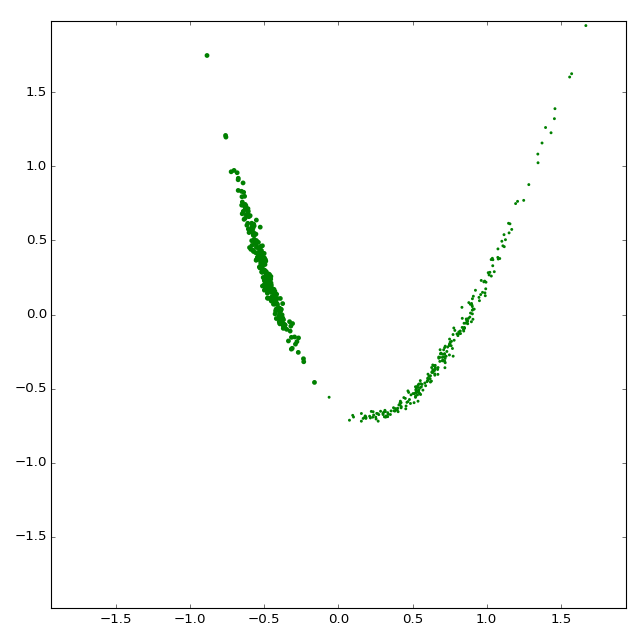

In [94]:
w_d = W_d.data.cpu().numpy() ; x_d = X_d.data.cpu().numpy()

fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(1,1,1)
#GroundTruth.plot(ax, 'b')
ax.scatter( x_d[:,0], x_d[:,1], 6400*w_d, 'g', edgecolors='none' )
plt.axis('equal') 
ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
plt.tight_layout()  ; fig.canvas.draw()


In [95]:
MyModel = GenerativeModel(degree = 3)
(W_t, X_t) = MyModel(NPOINTS)

<IPython.core.display.Javascript object>


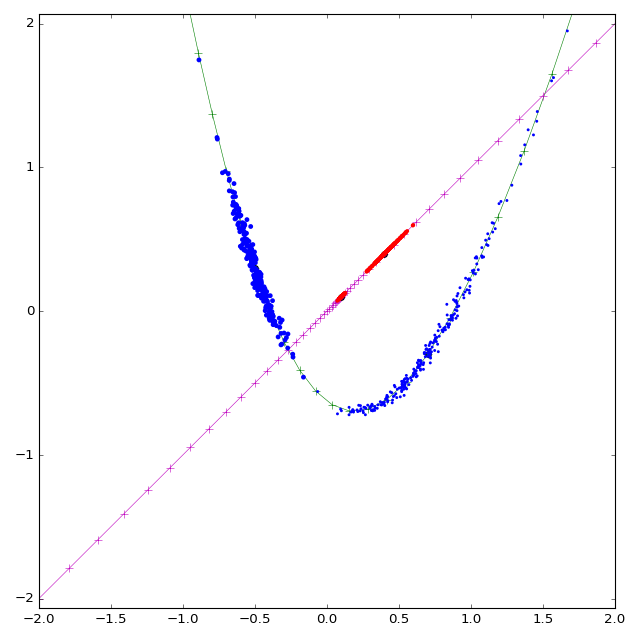

In [96]:
w_d = W_d.data.cpu().numpy() ; x_d = X_d.data.cpu().numpy()
w_t = W_t.data.cpu().numpy() ; x_t = X_t.data.cpu().numpy()

fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(1,1,1)
GroundTruth.plot(ax, 'g')
MyModel.plot(ax, 'm')
ax.scatter( x_d[:,0], x_d[:,1], 6400*w_d, 'b', edgecolors='none' )
ax.scatter( x_t[:,0], x_t[:,1], 6400*w_t, 'r', edgecolors='none' )

plt.axis('equal') 
ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
plt.tight_layout()  ; fig.canvas.draw()

In [97]:
def plot_situation(fig, ax, ground_truth,     mymodel, 
                            training_measure, generated_measure,
                            info_type,        info             ) :
    # Turn PyTorch variables into numpy arrays --------------------------
    w_d =  training_measure[0].data.cpu().numpy()
    x_d =  training_measure[1].data.cpu().numpy()
    w_t = generated_measure[0].data.cpu().numpy()
    x_t = generated_measure[1].data.cpu().numpy()
    
    # Remove the colorbar if any, clear the axis ------------------------
    if len(ax.images) > 0 :
        cbars = ax.images[0].colorbar
        if cbars is not None : 
            cbars.remove()
    ax.clear()
    
    # Plot the "info" image/transport-plan, if any ----------------------
    if info is not None :
        info  = info.data.cpu().numpy()
        if info_type == "heatmap" :     # The info is a signal defined on the plane
            scale = np.amax(np.abs(info)) * 1.5
            cax   = ax.imshow(info, interpolation='bilinear', origin='lower', 
                      vmin = -scale, vmax = scale, cmap=cm.bwr, 
                      extent=(-2,2, -2, 2), zorder=-2)
            cbar  = fig.colorbar(cax)
        elif info_type == "transport" : # The info is a transport plan between the two measures
            segs = []
            Q_weights,Q_points = w_t,x_t  ;  targetpoints = x_d
            for (a, mui, gi) in zip(Q_points, Q_weights, info) :
                gi = gi / mui # gi[j] = fraction of the mass from "a" which goes to xtpoints[j]
                for (xj, gij) in zip(targetpoints, gi) :
                    mass_per_line = 0.02
                    if gij >= mass_per_line :
                        nlines = np.floor(gij / mass_per_line)
                        ts     = np.linspace(-.005*(nlines-1), .005*(nlines-1), nlines)
                        for t in ts :
                            b = xj + t*np.array([ xj[1]-a[1], -xj[0]+a[0]])
                            segs += [[a, b]]
                            
            line_segments = LineCollection(np.array(segs), linewidths=(.3,), 
                                           colors=[(.6,.8,1.)]*len(segs), linestyle='solid', zorder=-1)
            ax.add_collection(line_segments)
    
    # Plot the model "embeddings", and the associated point clouds ------
    ground_truth.plot(ax, 'g')
    mymodel.plot(ax, 'm')
    ax.scatter( x_d[:,0], x_d[:,1], 6400*w_d, 'b', edgecolors='none' )
    ax.scatter( x_t[:,0], x_t[:,1], 6400*w_t, 'r', edgecolors='none' )
    
    # Ready to plot ! ---------------------------------------------------
    plt.axis('equal')  ; plt.tight_layout() ; ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
    fig.canvas.draw()

In [98]:
def FitModel(Model, Fidelity, EmpiricMeasure, name = "model", info_type = "heatmap", **kwargs) :
    N = len(EmpiricMeasure[0])
    optimizer = torch.optim.Adam(Model.parameters(), lr=.1)
    fig = plt.figure(figsize=(10,8))
    ax  = plt.subplot(1,1,1)
    costs = []
    for i in range(401) :
        optimizer.zero_grad()
        GeneratedMeasure = Model(N)
        Cost, info = Fidelity( GeneratedMeasure, EmpiricMeasure, info = (i%10==0), **kwargs )
        Cost.backward(retain_graph=True)
        costs.append(Cost.data.cpu().numpy()[0])
        if i % 10 == 0:
            print("Iteration ",i,"Cost = ", Cost.data.cpu().numpy()[0])
            plot_situation(fig, ax, GroundTruth,    Model, 
                                    EmpiricMeasure, GeneratedMeasure,
                                    info_type, info                   )
            fig.savefig('output/'+name+'_'+str(i)+'.png', dpi=fig.dpi)
        optimizer.step()
    fig = plt.figure(figsize=(8,8))
    ax  = plt.subplot(1,1,1)
    ax.plot(np.array(costs))

In [99]:
def kernel_product(x,y,nu, mode, s) :
    x_i = x.unsqueeze(1) ; y_j = y.unsqueeze(0)
    xmy = ((x_i-y_j)**2).sum(2)
    if   mode == "gaussian" : K = torch.exp( - xmy / (s**2) )
    elif mode == "energy"   : K = torch.pow( xmy + (s**2), -.25 )
    return K @ (nu.view(-1,1))

In [100]:
def kernel_scalar_product(Mu, Nu, mode, s) :
    (mu, x) = Mu ; (nu, y) = Nu
    k_nu = kernel_product(x,y,nu,mode,s)
    return torch.dot( mu.view(-1), k_nu.view(-1))

In [101]:
def kernel_distance(Mu, Nu, info = False, mode = "gaussian", s = 1.) :
    D2 =   (   kernel_scalar_product(Mu,Mu,mode,s) \
           +   kernel_scalar_product(Nu,Nu,mode,s) \
           - 2*kernel_scalar_product(Mu,Nu,mode,s) )
    
    kernel_heatmap = None
    if info :
        res    = 100 ; ticks = np.linspace( -2, 2, res + 1)[:-1] + 1/(2*res) 
        X,Y    = np.meshgrid( ticks, ticks )
        points = Variable(torch.from_numpy(np.vstack( (X.ravel(), Y.ravel()) ).T).type(dtype), requires_grad=False)

        kernel_heatmap   = kernel_product(points, Mu[1], Mu[0], mode, s) \
                         - kernel_product(points, Nu[1], Nu[0], mode, s)
        kernel_heatmap   = kernel_heatmap.view(res,res)
    return D2, kernel_heatmap

<IPython.core.display.Javascript object>


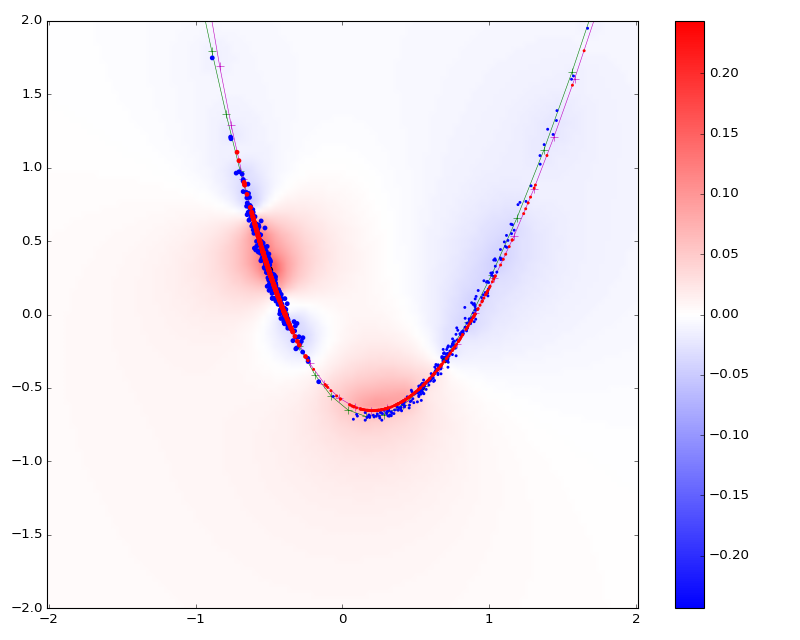

Iteration  0 Cost =  2.27303
Iteration  10 Cost =  0.653184
Iteration  20 Cost =  0.470758
Iteration  30 Cost =  0.36999
Iteration  40 Cost =  0.327043
Iteration  50 Cost =  0.251902
Iteration  60 Cost =  0.247998
Iteration  70 Cost =  0.209835
Iteration  80 Cost =  0.183636
Iteration  90 Cost =  0.106567
Iteration  100 Cost =  0.0903203
Iteration  110 Cost =  0.0781109
Iteration  120 Cost =  0.0780349
Iteration  130 Cost =  0.0699515
Iteration  140 Cost =  0.0403125
Iteration  150 Cost =  0.0318046
Iteration  160 Cost =  0.0374949
Iteration  170 Cost =  0.0327802
Iteration  180 Cost =  0.0364919
Iteration  190 Cost =  0.0295711
Iteration  200 Cost =  0.0383234
Iteration  210 Cost =  0.0412688
Iteration  220 Cost =  0.0311716
Iteration  230 Cost =  0.0251422
Iteration  240 Cost =  0.0401793
Iteration  250 Cost =  0.0253849
Iteration  260 Cost =  0.0273957
Iteration  270 Cost =  0.0259943
Iteration  280 Cost =  0.0339818
Iteration  290 Cost =  0.0369134
Iteration  300 Cost =  0.0346026


<IPython.core.display.Javascript object>


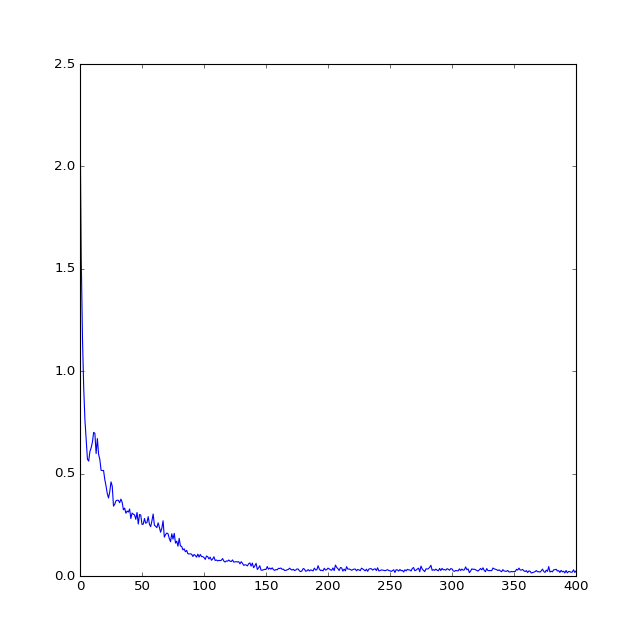

In [102]:
MyModel = GenerativeModel(degree = 2)
FitModel(MyModel, kernel_distance, (W_d, X_d), mode = "energy", s=.05)

In [103]:
def wasserstein_distance(Mu, Nu, info = False, s = .2) :
    """
    Executes the Sinkhorn algorithm to compute an approximate Optimal Transport
    cost between Mu and Nu, using an entropic regularization of strength
    epsilon = s^2.
    """
    A = Variable(torch.ones(Mu[0].size()).type(dtype))
    B = Variable(torch.ones(Nu[0].size()).type(dtype))
    for it in range(1000) :
        A_prev = A
        A = Mu[0] / kernel_product(Mu[1], Nu[1], B,"gaussian",s).view(-1)
        B = Nu[0] / kernel_product(Nu[1], Mu[1], A,"gaussian",s).view(-1)
        err = (A-A_prev).abs().mean().data.cpu().numpy()
        if err < 1e-5 :
            print(it, ", ", end="")
            break
        
    D2 = kernel_scalar_product((A,Mu[1]), (B,Nu[1]), "gaussian", s)
    transport_plan = None
    return D2, transport_plan

In [104]:
#MyModel = GenerativeModel(degree = 2)
#FitModel(MyModel, wasserstein_distance, (W_d, X_d), name = "wasserstein", s = .5)

In [105]:
def log_sum_exp(mat, dim):
    max_rc = torch.max(mat, dim)[0]
    return max_rc + torch.log(torch.sum(torch.exp(mat - max_rc.unsqueeze(dim)), dim))

def wasserstein_distance_log(Mu, Nu, info = False, s = .2) :
    """
    Log-domain implementation of the Sinkhorn algorithm,
    for numerical stability.
    The "multiplicative" standard implementation is replaced
    by an "additive" logarithmic one, as:
    - A is replaced by U = eps * log(A)
    - B is replaced by V = eps * log(A)
    - K_ij is replaced by C_ij = - eps * log(K_ij)
                               = |X_i-Y_j|^2
    (remember that epsilon = eps = s^2)
    
    The update step:
    
    " a_i = mu_i / \sum_j k(x_i,y_j) b_j "
    
    is thus replaced, applying eps*log(...) on both sides, by
    
    " u_i = eps*[ log(mu_i) - log(sum( exp(-C_ij/eps) * exp(v_j/eps) )) ]
          = eps*[ log(mu_i) - log(sum( exp((v_j-C_ij)/eps ))            ]
          = eps*[ log(mu_i) - log(sum( exp((u_i+v_j-C_ij)/eps))) + u_i/eps  ]
    
    
    """
    U   = Variable(torch.zeros(Mu[0].size()).type(dtype))
    V   = Variable(torch.zeros(Nu[0].size()).type(dtype))
    C   = ((Mu[1].unsqueeze(1) - Nu[1].unsqueeze(0) )**2).sum(2)
    tau = -.5
    eps = s**2
    for it in range(1000) :
        U_prev = U
        U = tau*U + (1-tau)*eps*( torch.log(Mu[0]) - log_sum_exp( (V.view(1,-1) - C) / eps, dim=1 ).view(-1) )
        V = tau*V + (1-tau)*eps*( torch.log(Nu[0]) - log_sum_exp( (U.view(-1,1) - C) / eps, dim=0 ).view(-1) )
                 
        err = (U-U_prev).abs().mean().data.cpu().numpy()
        if err < 1e-5 :
            print(it, ", ", end="")
            break
         
    D2 = (( (U.view(-1,1)+V.view(1,-1) - C) / eps ).exp() * C).sum()
    transport_plan = None
    if info :
        transport_plan = ((U.view(-1,1)+V.view(1,-1) - C) / eps ).exp()
    return D2, transport_plan

<IPython.core.display.Javascript object>


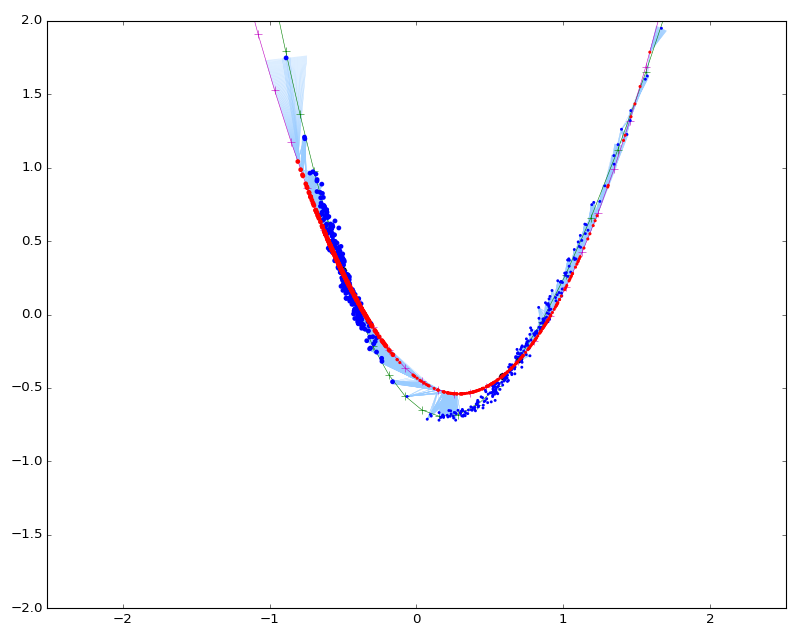

17 , Iteration  0 Cost =  0.584828


/home/jean/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


19 , 41 , 51 , 53 , 57 , 57 , 49 , 81 , 99 , 96 , Iteration  10 Cost =  0.193815
116 , 81 , 130 , 125 , 82 , 235 , 288 , 231 , 188 , 200 , Iteration  20 Cost =  0.115875
153 , 209 , 186 , 252 , 222 , 146 , 162 , 124 , 172 , 95 , Iteration  30 Cost =  0.0635742
150 , 123 , 172 , 215 , 227 , 143 , 202 , 208 , 47 , 135 , Iteration  40 Cost =  0.0512463
90 , 105 , 177 , 166 , 192 , 64 , 195 , 167 , 150 , 199 , Iteration  50 Cost =  0.0339192
166 , 191 , 111 , 150 , 160 , 157 , 169 , 180 , 168 , 185 , Iteration  60 Cost =  0.0371427
173 , 217 , 178 , 248 , 271 , 254 , 231 , 216 , 181 , 113 , Iteration  70 Cost =  0.0384121
233 , 155 , 164 , 243 , 206 , 180 , 223 , 198 , 145 , 232 , Iteration  80 Cost =  0.0310282
183 , 210 , 202 , 269 , 258 , 182 , 278 , 239 , 174 , 306 , Iteration  90 Cost =  0.0280147
166 , 219 , 201 , 210 , 242 , 217 , 91 , 228 , 210 , 178 , Iteration  100 Cost =  0.0252171
245 , 261 , 195 , 193 , 221 , 190 , 286 , 283 , 200 , 87 , Iteration  110 Cost =  0.0263292
219 , 

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503968623488/work/torch/lib/THC/generic/THCStorage.cu:66

In [106]:
MyModel = GenerativeModel(degree = 2)
FitModel(MyModel, wasserstein_distance_log, (W_d, X_d), info_type = "transport", name = "wasserstein", s = .15)